In [1]:
# Auto loading
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from rotation_3d import tricubic_derivatives,tricubic_interp
from rotation_3d import rot_cost_func_3d
from visualize import plot_cost_func
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
sept23_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_10.p','rb'))
sept23_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_8.p','rb'))
sept23_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_6_4.p','rb'))
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Sept_23_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


Let $V^S$ denote the source volume, and $V^T$ denote the target volume.  We want to find a transformation from source to target so that their sum of squared difference is minimal. The cost function we have chosen is the sum of squared differences between the two volume at each voxel, defined as, 
$$f = \sum\limits_{i}(V^S(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^T)^2,$$ 
where $\boldsymbol{x_i}$ is the voxel location, and $\boldsymbol{d}(\boldsymbol{P})$ is the replacement from source to target given the set of parameters $\boldsymbol{P}$. We need to minimize this cost function with respect to the set of six transformation parameters $\boldsymbol{P}$. 

Gauss-Newton method allows us to find the minimum of a least squared function through iterative procedures. Let 
$$\begin{align}
r_i(\boldsymbol{P}) = V^S(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^T (1)
\end{align}$$

Then the iteration goes as follows,
$$\boldsymbol{P}^{s+1} = \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s}),$$
where 

$$(\mathbf{J_r})_{ij} = \frac{\partial r_i (\boldsymbol P^{(s)})}{\partial P_j}$$

$$=\frac{\partial r_i (\boldsymbol P^{(s)})}{\partial \boldsymbol{d}(P_j)}\frac{\partial \boldsymbol{d}(P_j)}{\partial P_j}$$

Now the problem boils down to simplifying the computation for the Jacobian. If we take the gradient of $r_i(\boldsymbol{P})$ using equation (1) we get,

$$
\frac{\partial r_i (\boldsymbol{P})}{\partial P_j} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \frac{\partial \boldsymbol{d}(P_j)}{\partial P_j}$$

where $\nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)}$ is the partial derivatives of the source volume at voxel $i$ with respect to the three coordinate directions, which is computed already during tricubic interpolation. Since the displacement between the two volumes are relatively small,  we can model the small rotations as a translation.

$$\boldsymbol{d(\boldsymbol{P})} = \boldsymbol{M}\boldsymbol{P},$$
where

$$
\boldsymbol{M} = 
\begin{bmatrix}
1 & 0 & 0 & 0 & x_3 & -x_2\\
0 & 1 & 0 & -x_3 & 0 & x_1\\
0 & 0 & 1 & x_2 & -x_1 & 0\\
\end{bmatrix}$$

Hence, 
$$\frac{\partial \boldsymbol{d}(P)}{\partial P} = \boldsymbol{M}$$
$$\frac{\partial \boldsymbol{d}(P)}{\partial P_j} = \boldsymbol{M}[:,j]$$
$$\frac{\partial r_i (\boldsymbol{P})}{\partial P_j} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]$$

$$
(\mathbf{J_r})_{ij} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]
$$

Notice that we still need to compute $\nabla_{\boldsymbol{x}}\boldsymbol{V^S}$ at each step for each voxel, which can be very expensive, so to save computation, we can calculate the displacement on the target volume $V^T$. 
Suppose now we pretend to move the target volume to the source volume instead, then
$$f = \sum\limits_{i}(V^T(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^S)^2,$$
and if we follow the steps we will end up with 
$$\boldsymbol{P}^{s+1} = \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s}),$$
where 
$$(\mathbf{J_r})_{ij} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^T(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]$$
We can now move $V^S$ by $-\boldsymbol{P}$, and continue with the iteration. This way, we only need to compute $\nabla_{\boldsymbol{x}_i}\boldsymbol{V^T(\boldsymbol{x}_i)} $ once, and in every iteration it remains constant.

In [121]:
# Function to compute the derivatives for the target volume
def axis_derivatives(volume):
    shape = volume.shape
    tricubic_derivative_dict = {}
    for i in xrange(0,shape[0]):
        for j in xrange(0,shape[1]):
            for k in xrange(0,shape[2]):
                # Take care of boundary conditions
                x1 = i
                y1 = j
                z1 = k
                x0 = x1 - 1
                x2 = x1 + 1
                y0 = y1 - 1
                y2 = y1 + 1
                z0 = z1 - 1
                z2 = z1 + 1
                
#                     # Wrap Around
#                 x0 = (x0 + volume.shape[1]) % volume.shape[1]
#                 x2 = (x2 + volume.shape[1]) % volume.shape[1]
#                 y0 = (y0 + volume.shape[0]) % volume.shape[0]
#                 y2 = (y2 + volume.shape[0]) % volume.shape[0]
#                 z0 = (z0 + volume.shape[2]) % volume.shape[2]
#                 z2 = (z2 + volume.shape[2]) % volume.shape[2] 

#                 # Wrap around original grid points
#                 x1 = (x1 + volume.shape[1]) % volume.shape[1]
#                 y1 = (y1 + volume.shape[0]) % volume.shape[0]
#                 z1 = (z1 + volume.shape[2]) % volume.shape[2]
                
                x0 = np.clip(x0, 0, volume.shape[1]-1)
                x1 = np.clip(x1, 0, volume.shape[1]-1)
                x2 = np.clip(x2, 0, volume.shape[1]-1)
                y0 = np.clip(y0, 0, volume.shape[0]-1)
                y1 = np.clip(y1, 0, volume.shape[0]-1)
                y2 = np.clip(y2, 0, volume.shape[0]-1)
                z0 = np.clip(z0, 0, volume.shape[2]-1)
                z1 = np.clip(z1, 0, volume.shape[2]-1)
                z2 = np.clip(z2, 0, volume.shape[2]-1)

                # Compute vector Y from known points
                Y = np.zeros([3,])

                # values of df/dx at each corner.
                Y[1] = ((volume[y1,x2,z1]-volume[y1,x0,z1])/2.)
                # values of df/dy at each corner.
                Y[0] = ((volume[y2,x1,z1]-volume[y0,x1,z1])/2.)
                # values of df/dz at each corner.
                Y[2] = ((volume[y1,x1,z2]-volume[y1,x1,z0])/2.)

                tricubic_derivative_dict[(i,j,k)] = Y
    return tricubic_derivative_dict

In [166]:
def rotate_coords_transformation_m(x, y, z, params, ox,oy,oz, k=16.):
    l = np.sqrt(params[3]**2+params[4]**2+params[5]**2)/k
    if(l == 0):
        return (x,y,z)
    s,c = np.sin(l/2.),np.cos(l/2.)
    alpha = c
    beta = s*params[4]/l
    gamma = s*params[3]/l
    delta = s*params[5]/l

    x, y, z = x - ox, y - oy, z - oz
    rotx = (alpha**2+beta**2-gamma**2-delta**2)*x+2*(beta*gamma-alpha*delta)*y+2*(beta*delta+alpha*gamma)*z+ox+params[0]
    roty = (alpha**2-beta**2+gamma**2-delta**2)*y+2*(beta*gamma+alpha*delta)*x+2*(gamma*delta-alpha*beta)*z+oy+params[0]
    rotz = (alpha**2-beta**2-gamma**2+delta**2)*z+2*(gamma*delta+alpha*beta)*y+2*(beta*delta-alpha*gamma)*x+oz+params[0]

    return (rotx,roty,rotz)

In [142]:
def get_M(x1_org,x2_org,x3_org,k=16.):
    x1 = x1_org/k
    x2 = x2_org/k
    x3 = x3_org/k
    M = np.array([[1,0,0,0,x3,-x2],[0,1,0,-x3,0,x1],[0,0,1,x2,-x1,0]])
    return M

In [9]:
def to_degree(radian):
    return radian*180/np.pi

def trace_plot(Ps,res):
    arr = np.array(Ps)
    plt.figure(figsize = [12,4])
    plt.subplot(1,2,1)
    for i in xrange(3):
        plt.plot(arr[:,i]*res,label = 't_%s'%i)
    plt.legend(loc = 'best')
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('Translations (mm)', fontsize = 15)
    plt.subplot(1,2,2)
    for j in xrange(3,6):
        plt.plot(to_degree(arr[:,j]),label = 'R_%s'%j)
    plt.legend(loc = 'best')
    plt.suptitle('Trace Plot for the Transformation Parameters',fontsize=18)
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('Rotations (degrees)', fontsize = 15)
    plt.show()
    
def plot_errors(errors):
    plt.plot(errors[1:])
    plt.title('Trace Plot for Errors',fontsize = 18)
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('SSD Error', fontsize = 15)
    plt.show()
    
def convert_params(params,res):
    print 'translation (in mm):', params[:3]*res
    print 'rotations (in degrees):', params[3:]*180/np.pi
    
def print_results(errors, Ps, res):
    print 'min error: ', errors[-1]
    params = Ps[-1]
    print 'parameters at min error: ', params
    print 'translation (in mm):', params[:3]*res
    print 'rotations (in degrees):', params[3:]*180/np.pi

In [352]:
# Get two volumes to register
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

# Get the mesh_grid points for the volume
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5
derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)
#derivatives = axis_derivatives(testVol1)
#tricubic_cache = tricubic_derivatives(testVol2)

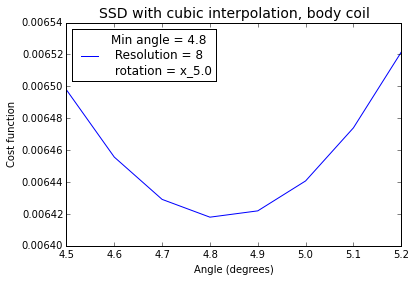

In [353]:
# Test tricubic interpolation on 8mm, x-axis rotation
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

thetas = np.arange(4.5,5.2,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_masked, testVol2_masked, thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

**Step 1: Compare derivatives of image 1 with respect to the coordinate axes **

In [15]:
img1Derivs = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img1Derivs.dat', dtype=np.float32, mode='c', shape=(3,32,32,32)))
img2Derivs = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img2Derivs.dat',dtype=np.float32,mode='c',shape=(3,32,32,32)))

In [162]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(img1Derivs[:,i,j,k], -1.*derivatives[(j,i,k)]):
                count += 1
                print i,j,k
print count

0


In [163]:
derivatives_vol2 = axis_derivatives(testVol2)
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(img2Derivs[:,i,j,k], -1.*derivatives_vol2[(j,i,k)]):
                count += 1
                print i,j,k
print count

0


**Step 2: Compare M Tensor and img1Gradiaent**

In [59]:
img1GradP = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img1GradP.dat', dtype=np.float32, mode='c', shape=(32,32,32,6)))
MTensor = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/MTensor.dat',dtype=np.float32,mode='c',shape=(32,32,32,6,3)))

In [105]:
MT = np.empty([32,32,32,6,3])
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            M = get_M(yy[i,j,k]-15.5,xx[i,j,k]-15.5,zz[i,j,k]-15.5)
            MT[i,j,k,:,:] = M.T

In [164]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MTensor[i,j,k,:,:], MT[i,j,k,:,:]):
                count += 1
                print i,j,k
print count

0


In [165]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MT[i,j,k,:,:].dot(-derivatives[j,i,k]),img1GradP[i,j,k,:],1e-5,1e-7):
                count += 1
                print i,j,k
print count

0


In [166]:
img1GradP[i,j,k,:].shape

(6,)

**Step 3: Compare JTransJ and JTransr**

In [127]:
JTransJ = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/JTransJ.dat',dtype=np.float32,mode='c',shape=(6,6)))

In [189]:
jTj = np.zeros([6,6])
jTr = np.zeros([6,1])
r = testVol2-testVol1

for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            tmp = (MT[i,j,k,:,:].dot(-derivatives[j,i,k])).reshape([1,6])
            jTj += tmp.T.dot(tmp)
            jTr -= tmp.T*(r[i,j,k])

In [190]:
np.allclose(jTj,JTransJ)

True

In [191]:
jTr

array([[-0.05516286],
       [-0.01742106],
       [ 0.00436957],
       [-0.07831883],
       [ 0.16866634],
       [-0.49359507]])

In [194]:
np.linalg.solve(jTj,jTr)

array([[-0.11947555],
       [-0.04306539],
       [ 0.02137844],
       [ 0.00104204],
       [-0.00155372],
       [-0.04679049]])

In [32]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)

# Get the mesh_grid points for the volume
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

In [174]:
# Get two volumes to register
rot_ax = 'z'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)

# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5

In [175]:
P_s = np.array([0,0,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.0125651922879


In [176]:
P_s = np.array([0,0,0,0,0,-to_radian(5)])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.00505054020656


0 1 2 3 4 5 6 7 8 9 10 Converged in 10 iterations!


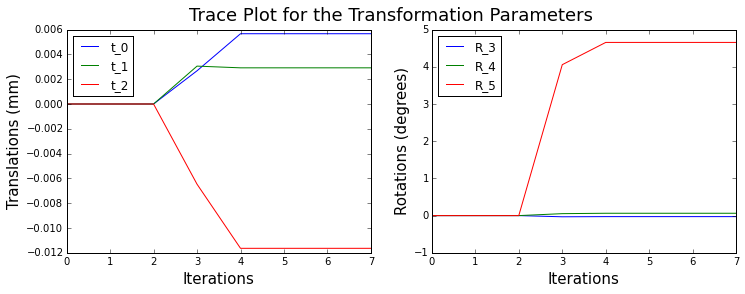

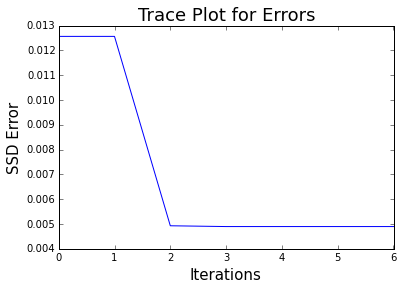

min error:  0.00489686130261
parameters at min error:  [ 0.00070839  0.00036465 -0.00145479 -0.00047734  0.00109826  0.08125178]
translation (in mm): [ 0.00566713  0.00291719 -0.01163831]
rotations (in degrees): [-0.02734938  0.06292573  4.655384  ]


In [177]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked)
print_results(errors_z, Ps_z, 8)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Converged in 18 iterations!


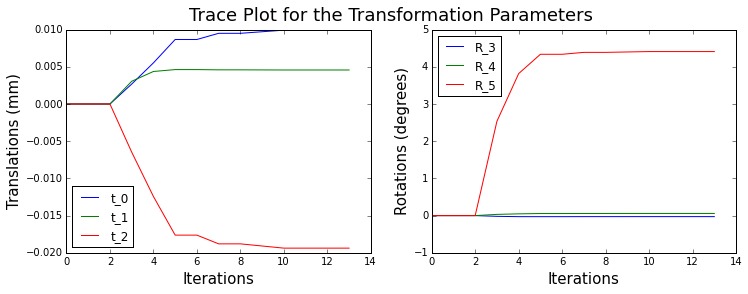

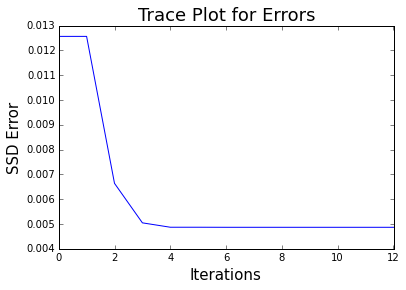

min error:  0.00486702411041
parameters at min error:  [ 0.00124046  0.00057141 -0.00242164 -0.00047854  0.00100994  0.07695765]
translation (in mm): [ 0.00992365  0.00457128 -0.01937309]
rotations (in degrees): [-0.02741851  0.05786525  4.40934842]


In [178]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked,divide_factor = 10)
print_results(errors_z, Ps_z, 8)

In [153]:
def Gauss_Newton(Vol1, Vol1_derivatives, Vol2,Vol2_derivatives, alpha = 0.2, P_initial = np.array([0,0,0,0,0,0]), plot = True):

    Ps = []
    P_old = P_initial.copy()
    P_new = P_old.copy()
    Ps.append(P_new)
    errors = []
    errors.append(1.0)
    
    volume_shape = Vol1.shape
    for counter in xrange(20):
        print counter,
        #print P_s
        P_old = P_new.copy()
        
        # Get the new coordinates by rotating the volume by the opposite amount of P_s
        dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, -1.*P_old, ox, oy, oz)
        # Initilization
        Jr = np.empty([volume_shape[0]*volume_shape[1]*volume_shape[2],6])
        Jr_rP = np.zeros([6,])
        dest = np.empty(volume_shape)
        idx = 0
        for i in xrange(volume_shape[0]):
            for j in xrange(volume_shape[1]):
                for k in xrange(volume_shape[2]):
                    dest[i,j,k] = tricubic_interp(volume_shape,Vol2_derivatives,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
                    M = get_M(yy[i,j,k]-ox,xx[i,j,k]-oy,zz[i,j,k]-oz)
                    for ii in xrange(len(P_old)):
                        Jr[idx,ii] = -1.*Vol1_derivatives[j,i,k].dot(M[:,ii])
                        Jr_rP[ii] += Jr[idx,ii]*(Vol1[yy[i,j,k],xx[i,j,k],zz[i,j,k]]-dest[i,j,k])
                    idx += 1
        error = cf_ssd(Vol1,dest)

        ## if error is getting larger, go back one step and decrease alpha
        if(error > errors[-1]):
            alpha = alpha * 0.25
            P_new = Ps[-1]
        else:
            #print abs(error-errors[-1])
            errors.append(error)
            Ps.append(P_old)
            P_new = P_old - alpha*np.dot(np.linalg.inv(np.dot(Jr.T,Jr)),Jr_rP)
            if((abs(P_new - P_old) < 1e-5).all()):
                print 'Converged in %s iterations!' % counter
                break
    if(plot):
        if (volume_shape[0] == 26): res = 10.0
        if (volume_shape[0] == 32): res = 8.0
        if (volume_shape[0] == 40): res = 6.4
        trace_plot(Ps, res)
        plot_errors(errors)
    return errors, Ps

In [170]:
# Get two volumes to register
rot_ax = 'y'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)

# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5

In [123]:
P_s = np.array([0,0,0,0,-to_radian(5),0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.00469517912784


In [ ]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked)
print_results(errors_z, Ps_z, 8)

In [193]:
def Gauss_Newton(Vol1, Vol1_derivatives, Vol2, Vol2_derivatives, 
                 divide_factor = 16., alpha = 0.2, decrease_factor = 0.25, 
                 P_initial = np.array([0,0,0,0,0,0]), plot = True, max_iter = 20):

    volume_shape = Vol1.shape
    if (volume_shape[0] == 26): res = '10'
    if (volume_shape[0] == 32): res = '8'
    if (volume_shape[0] == 40): res = '6_4'
    xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
    ox = volume_shape[1]/2.-0.5
    oy = volume_shape[0]/2.-0.5
    oz = volume_shape[2]/2.-0.5
    Ps = []
    P_old = P_initial.copy()
    P_new = P_old.copy()
    Ps.append(P_new)
    errors = []
    errors.append(1.0)
    
    for counter in xrange(max_iter):
        print counter,
        #print P_s
        P_old = P_new.copy()
        
        # Get the new coordinates by rotating the volume by the opposite amount of P_s
        dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, -1.*P_old, ox, oy, oz,divide_factor)
        #print dest_x
        # Initilization
        Jr = np.empty([volume_shape[0]*volume_shape[1]*volume_shape[2],6])
        Jr_rP = np.zeros([6,])
        dest = np.empty(volume_shape)
        idx = 0
        for i in xrange(volume_shape[0]):
            for j in xrange(volume_shape[1]):
                for k in xrange(volume_shape[2]):
                    dest[i,j,k] = tricubic_interp(volume_shape,Vol2_derivatives,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
                    M = get_M(yy[i,j,k]-ox,xx[i,j,k]-oy,zz[i,j,k]-oz,divide_factor)
                    for ii in xrange(len(P_old)):
                        Jr[idx,ii] = -1.*Vol1_derivatives[j,i,k].dot(M[:,ii])
                        Jr_rP[ii] += Jr[idx,ii]*(Vol1[yy[i,j,k],xx[i,j,k],zz[i,j,k]]-dest[i,j,k])
                    idx += 1
        error = cf_ssd(Vol1,dest)

        ## if error is getting larger, go back one step and decrease alpha
        if(error > errors[-1]):
            alpha = alpha * decrease_factor
            P_new = Ps[-1]
        else:
            #print abs(error-errors[-1])
            errors.append(error)
            Ps.append(P_old)
            P_new = P_old - alpha*np.dot(np.linalg.inv(np.dot(Jr.T,Jr)),Jr_rP)
            if((abs(P_new - P_old) < 1e-5).all()):
                print 'Converged in %s iterations!' % counter
                break
    if(plot):
        trace_plot(Ps, float('.'.join(res.split('_'))))
        plot_errors(errors)
    return errors, Ps

In [189]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1_trans = sphere_mask(oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)],rad)
testVol2_trans = sphere_mask(oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)],rad)

vol1_dervs = axis_derivatives(testVol1_trans)
vol2_dervs = tricubic_derivatives(testVol2_trans)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29

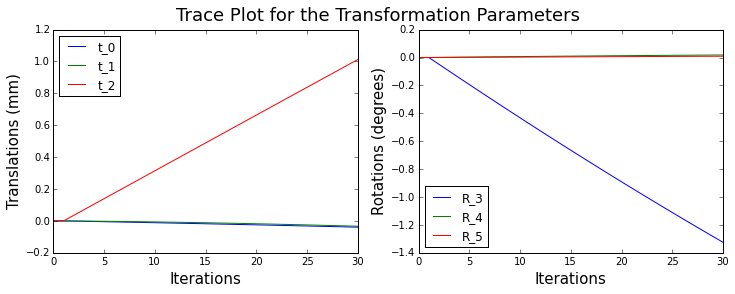

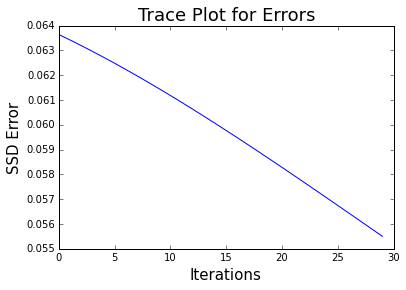

 min error:  0.0555045048572
parameters at min error:  [-0.00491483 -0.00417345  0.12652804 -0.02312236  0.00031604  0.00016172]
translation (in mm): [-0.03931861 -0.03338756  1.01222429]
rotations (in degrees): [-1.3248137   0.01810774  0.00926615]


In [194]:
errors, Ps = Gauss_Newton(testVol1_trans,vol1_dervs,testVol2_trans,vol2_dervs,divide_factor = 1.,alpha=0.01,max_iter = 30)
print_results(errors, Ps, 8)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 Converged in 17 iterations!


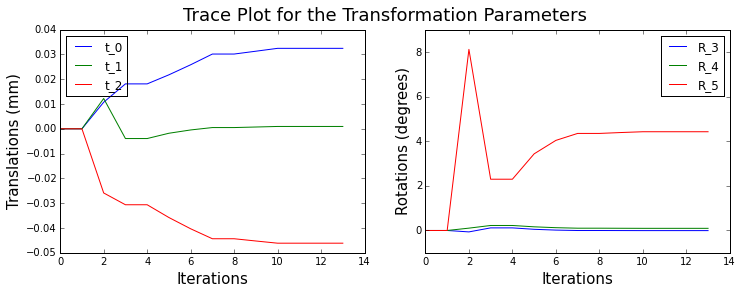

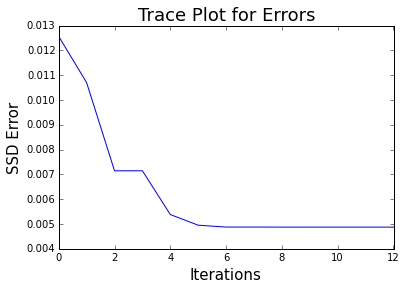

min error:  0.00487425241398
parameters at min error:  [  4.05571259e-03   1.18073932e-04  -5.76558122e-03  -9.82450058e-05
   1.67852891e-03   7.72127281e-02]
translation (in mm): [ 0.0324457   0.00094459 -0.04612465]
rotations (in degrees): [-0.00562902  0.09617262  4.42396344]


In [184]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked,divide_factor = 8.)
print_results(errors_z, Ps_z, 8)

0

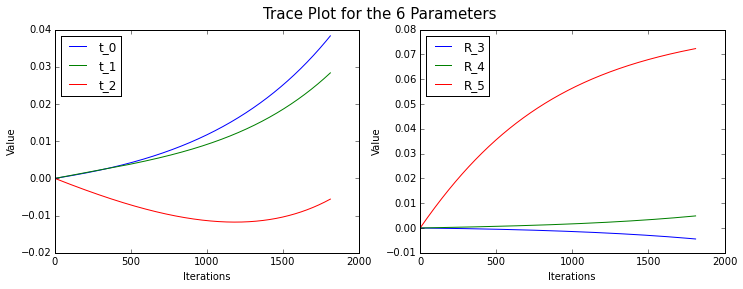

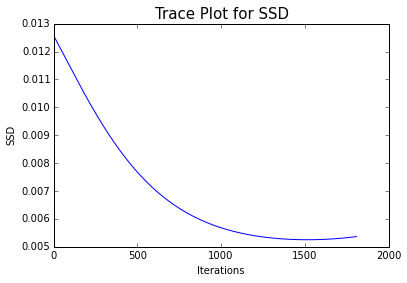

In [246]:
#Ps = []
alpha = 0.001

#P_s = np.array([0,0,0,0,0,0])
#P_s1 = P_s.copy()
#Ps.append(P_s1)
#errors = []
for counter in xrange(10):
    if(counter % 10 == 0):
        print counter,
    P_s = P_s1.copy()
    # Get the new coordinates by rotating the volume by the opposite amount of P_s
    dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, -1.*P_s, ox, oy, oz)
    # Initilization
    Jr = np.empty([volume_shape[0]*volume_shape[1]*volume_shape[2],6])
    Jr_rP = np.zeros([6,])
    dest = np.empty(volume_shape)
    idx = 0
    for i in xrange(volume_shape[0]):
        for j in xrange(volume_shape[1]):
            for k in xrange(volume_shape[2]):
                dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
                M = get_M(yy[i,j,k]-ox,xx[i,j,k]-oy,zz[i,j,k]-oz)
                for ii in xrange(len(P_s)):
                    Jr[idx,ii] = -1.*derivatives_masked[j,i,k].dot(M[:,ii])
                    Jr_rP[ii] += Jr[idx,ii]*(testVol1_masked[yy[i,j,k],xx[i,j,k],zz[i,j,k]]-dest[i,j,k])
                idx += 1
    errors.append(cf_ssd(testVol1_masked,dest))
    P_s1 = P_s - alpha*np.dot(np.linalg.inv(np.dot(Jr.T,Jr)),Jr_rP)
    Ps.append(P_s1)
trace_plot(Ps)
plot_errors(errors)

In [247]:
print_results(errors, Ps, 8)

min error:  0.00525287564177
parameters at min error:  [ 0.02570064  0.0190052  -0.01021305 -0.00303911  0.0033868   0.06817436]
translation (in mm): [ 0.20560511  0.1520416  -0.08170441]
rotations (in degrees): [-0.17412798  0.19404954  3.90610291]
